In [1]:
import pandas as pd
import cv2
import numpy as np

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import transforms
import torch.utils.data as data
from torch.utils.data.sampler import SubsetRandomSampler

import pickle
from tqdm.notebook import tqdm


In [2]:
def preprocess_data(directory:str, batch_size:int, test_size:int, rand_num:int, worker:int):
    '''
        directory: the directory of processed directory with class folders inside
        batch_size: size of batch for training
        test_size: percent of dataset used for test
        rand_num: put random number for reproducibility
        worker: number of worker in computation
        
        return train and test data ready for training
    '''
    #pipeline to resize images, crop, convert to tensor, and normalize
    trans = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])])
    
    dataset = torchvision.datasets.ImageFolder(root=directory, transform=trans) #read image in folder to data with labels
    
    train_len = len(dataset) #get length of whole data
    ind = list(range(train_len)) #indices of whole data
    spl = int(np.floor(test_size * train_len)) #index of test data
    
    #reproducibility and shuffle step
    np.random.seed(rand_num) 
    np.random.shuffle(ind)
    
    #sampling preparation steps
    train_id, test_id = ind[spl:], ind[:spl]
    tr_sampl = SubsetRandomSampler(train_id)
    te_sampl = SubsetRandomSampler(test_id)

    #use data loader to get train and test set ready for training
    trainloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=tr_sampl,num_workers=worker)
    testloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=te_sampl,num_workers=worker)
    return (trainloader, testloader)

In [3]:
dire = "./Data/Processed" # directory of dataset
# loading data loader
trainloader, testloader = preprocess_data(directory=dire, batch_size=16, test_size=0.3, rand_num=40, worker=4)
# getting device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# 
resnet101 = torchvision.models.resnet101

In [22]:
resnet50 = torchvision.models.resnet50(pretrained=True)
modules = list(resnet50.children())[:-1]
print(modules)
resnet50_model = nn.Sequential(*modules)

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False), BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), ReLU(inplace=True), MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False), Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=Tr

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch:[1/10], training loss: 3.1953
Epoch:[2/10], training loss: 0.9174
Epoch:[3/10], training loss: 0.3971
Epoch:[4/10], training loss: 0.2122
Epoch:[5/10], training loss: 0.1115
Epoch:[6/10], training loss: 0.0409
Epoch:[7/10], training loss: 0.0197
Epoch:[8/10], training loss: 0.0236
Epoch:[9/10], training loss: 0.0173
Epoch:[10/10], training loss: 0.0156


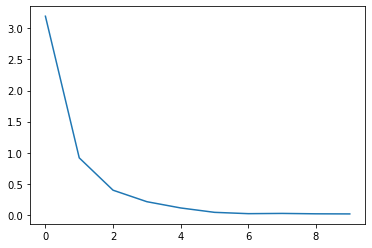

In [5]:
net = resnet50
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()
net = net.to(device)
losses = []
epochs = 10
for epoch in tqdm(range(epochs)):  # loop over the dataset multiple times
# YOUR CODE HERE
    Loss = 0.0
    count = 0
    for iter, data in enumerate(trainloader, 0):
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)

        predicted = net(images)
        _, pre1 = torch.max(predicted,dim=1)

        optimizer.zero_grad()
        loss = criterion(predicted, labels)
        loss.backward()
        optimizer.step()

        Loss += loss.item() #accumulate the loss
        count += 1

    avg_loss = Loss/count
    losses.append(avg_loss) #append the average loss for each batch
    print('Epoch:[{}/{}], training loss: {:.4f}'.format(epoch+1, epochs, avg_loss))

plt.plot(losses)

In [11]:
correct = 0
total = 0

# YOUR CODE HERE
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        y_hat = net(images)
        max_val, max_i = torch.max(y_hat.data, 1)
        print(y_hat)
        total += labels.size(0)
        correct += (max_i == labels).sum().item()
        
print(f'Accuracy of the network on the 10000 validation x: {100 * correct // total} %')

tensor([[10.7020,  8.6863, 18.5866,  ..., -1.4888,  0.7603,  2.1930],
        [ 5.8797,  5.6715, 18.9824,  ..., -2.2165, -0.6631,  3.1671],
        [ 9.3582, 10.6726, 11.1576,  ..., -0.3798, -0.1606,  0.2513],
        ...,
        [ 9.6668, 15.4612, 11.0755,  ..., -0.2377,  2.3062, -0.0742],
        [ 6.5263, 10.5423, 18.8167,  ..., -1.1789,  0.3268,  0.6900],
        [ 9.7677,  8.6550, 15.7375,  ..., -1.1307,  0.8119,  1.6364]],
       device='cuda:0')
tensor([[ 6.4883,  8.9786, 16.7473,  ..., -0.6835,  1.1350,  0.8391],
        [11.1874, 12.6418, 10.1867,  ...,  1.5446,  1.1793,  1.6521],
        [11.5479,  9.1854, 12.6125,  ..., -1.4003,  1.3933, -1.4129],
        ...,
        [11.5565, 11.3828, 10.7495,  ...,  0.4944, -0.1761,  1.2644],
        [ 8.4296,  7.2832, 14.6160,  ..., -2.4768,  0.5173,  2.5158],
        [ 5.4837,  8.3093, 17.3371,  ..., -1.6116,  1.5925,  1.6897]],
       device='cuda:0')
tensor([[ 7.4164,  8.2898, 16.8488,  ...,  2.2534,  0.9188,  1.9070],
        [ 8.19